In [1]:
import numpy as np 
import xarray as xr
import pandas as pd 
import os.path
import matplotlib.pyplot as plt 

In [2]:
def get_phase(RMM1, RMM2):
    if RMM1>=0 and RMM2>=0 and RMM1>=RMM2:
        return 5
    elif RMM1>=0 and RMM2>=0 and RMM1<=RMM2:
        return 6
    elif RMM1<=0 and RMM2>=0 and -RMM1<=RMM2:
        return 7
    elif RMM1<=0 and RMM2>=0 and -RMM1>=RMM2:
        return 8 
    elif RMM1<=0 and RMM2<=0 and RMM1<=RMM2:
        return 1
    elif RMM1<=0 and RMM2<=0 and RMM1>=RMM2:
        return 2 
    elif RMM1>=0 and RMM2<=0 and RMM1<=-RMM2:
        return 3
    elif RMM1>=0 and RMM2<=0 and RMM1>=-RMM2:
        return 4

In [3]:
def get_BCC(varn):
    # evaluate uncertainty in BCC
    ivarn = 0

    # set parameters for each run
    nmem = 1  # memory time steps
    yrsta = 1979  # starting year in training
    varnum = 1  # number of input maps
    yrlen = 36  # how many years in the training dataset. 94 is actually 114. 
    flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]
    # varn = ["olr"]  # "prep", 

    fnROMI = '/global/homes/l/linyaoly/ERA5/reanalysis/cal_ROMI/ROMI_ERA5_daily_'+str(yrsta)+'to2021.nc'  # file path for the obs ROMI
    dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/'+str(varnum)+'maps_MCDO_'+str(yrlen)+'yrtraining_ROMIERA5_filtered_'+flg+'_ens/ROMI_dp0102_1dmem_'+varn[ivarn]+'/'  # directory path for the output

    lead = [1, 5, 10, 15, 20, 25, 28, 30, 33]   # select the prediction lead
    # lead = [1, 5, 10, 13, 15, 25, 30]   # select the prediction lead
    # get initial phase
    iniROMI = xr.open_dataset(fnROMI)

    if nmem == 1:
        a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

    iniROMI = xr.concat((a,b), dim='time')
    del a 
    del b 
    ROMI1 = iniROMI['ROMI'][:,0]
    ROMI2 = iniROMI['ROMI'][:,1]
    Phase = np.zeros(len(ROMI1))

    for i in np.arange(len(ROMI1)):
        Phase[i] = get_phase(ROMI2[i],-ROMI1[i])

    # Phase

    # analyze error source and showing uncertainty
    ds = []
    dsp1 = []  # save all prediction files 
    pha_err = []
    BCC = []
    RMSE = []
    BCCctl = []
    RMSEctl = []

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
        # combine 2015-2019 prediction for the lead
        dsp = []  # ensemble forecast
        dst = []  # truth
        dspc = []  # control forecast

        for yn in np.arange(2015,2020):
            fnp=dirn + 'predicted_ens_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.nc'
            fnt=dirn + 'truth_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnpc=dirn + 'predicted_ctl_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            
            df = xr.open_dataset(fnp)
            dsp.append(df['ROMI'])
            del df 
            df = pd.read_csv(fnt,index_col=None, header=None, names=['ROMIt1','ROMIt2'])
            dst.append(df)
            del df 

            df = pd.read_csv(fnpc,index_col=None, header=None, names=['ROMIp1','ROMIp2'])
            dspc.append(df)
            del df 

        dsp0 = xr.concat(dsp, dim='timestp')
        dst0 = pd.concat(dst, axis=0, ignore_index=True)
        dspc0 = pd.concat(dspc, axis=0, ignore_index=True)

        ds0 = pd.concat((dspc0,dst0), axis=1)

        ds.append(ds0)
        del ds0
        del dst0
        del dst
        del dsp 

        iniROMI = xr.open_dataset(fnROMI)
        
        if nmem == 1:
            a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
            b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
        elif nmem == 30:
            a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
            b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

        iniROMI = xr.concat((a,b), dim='time')
        del a 
        del b 
        ROMI1 = iniROMI['ROMI'][:,0]
        ROMI2 = iniROMI['ROMI'][:,1]
        IniAmp = np.sqrt(ROMI1 * ROMI1 + ROMI2 * ROMI2)
        ds[ilead]['IniAmp'] = IniAmp.values 
        ds[ilead]['time'] =  iniROMI.time.values
        ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].time).month
        ds[ilead]['Phase'] = Phase

        dsp = xr.Dataset(
            data_vars=dict(
                ROMI=(["time", "N", "mode"], dsp0.values),
                IniAmp=(["time"], IniAmp.values),
            ),
            coords=dict(
                time=IniAmp.time,
                N=dsp0.N,
                mode=dsp0.mode,
            ),
        )

        # finish combination
        # evaluation starts 
        ds0 = ds[ilead].copy()
        dstmp = ds0.loc[ds0['IniAmp']>=1]
        dsp = dsp.where(dsp.IniAmp>1).dropna('time')
        ds[ilead] = dstmp.copy()
        del ds0 
        del dstmp

        # for ensemble forecast
        r1p = np.asarray(dsp['ROMI'][:,:,0].squeeze())  # time, Nsamp
        r2p = np.asarray(dsp['ROMI'][:,:,1].squeeze())
        r1t = np.asarray(ds[ilead]['ROMIt1'])  # time
        r2t = np.asarray(ds[ilead]['ROMIt2'])

        # BCC
        tmp = r1p*r1t[:,None]+r2p*r2t[:,None]
        a = np.sum(tmp, axis=0)
        b = np.sqrt(sum(r1t*r1t+r2t*r2t))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p, axis=0))
        BCC.append(a/b/c) 

        # RMSE
        d = (r1t[:,None]-r1p)*(r1t[:,None]-r1p)+(r2t[:,None]-r2p)*(r2t[:,None]-r2p)
        tmp = np.mean(d, axis=0)
        RMSE.append(np.sqrt(tmp))  # RMSE at each time step

        # for the control forecast
        r1p = np.asarray(ds[ilead]['ROMIp1'])  # time
        r2p = np.asarray(ds[ilead]['ROMIp2'])  # time
        r1t = np.asarray(ds[ilead]['ROMIt1'])  # time
        r2t = np.asarray(ds[ilead]['ROMIt2'])

        # BCC
        # tmp = r1p*r1t+r2p*r2t
        a = np.sum(r1p*r1t+r2p*r2t)
        b = np.sqrt(np.sum(r1t*r1t+r2t*r2t))
        c = np.sqrt(np.sum(r1p*r1p+r2p*r2p))
        BCCctl.append(a/b/c) 

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        tmp = np.mean(d)
        RMSEctl.append(np.sqrt(tmp))  # RMSE at each time step
    return BCC, RMSE, BCCctl, RMSEctl


In [4]:
BCC_olr, RMSE_olr, BCCctl_olr, RMSEctl_olr = get_BCC(["olr"])
BCC_u200, RMSE_u200, BCCctl_u200, RMSEctl_u200 = get_BCC(["u200"])

In [5]:
BCC_olr = np.asarray(BCC_olr)
BCCctl_olr = np.asarray(BCCctl_olr)
RMSE_olr = np.asarray(RMSE_olr)
RMSEctl_olr = np.asarray(RMSEctl_olr)
BCC_u200 = np.asarray(BCC_u200)
BCCctl_u200 = np.asarray(BCCctl_u200)
RMSE_u200 = np.asarray(RMSE_u200)
RMSEctl_u200 = np.asarray(RMSEctl_u200)


(0.0, 1.8)

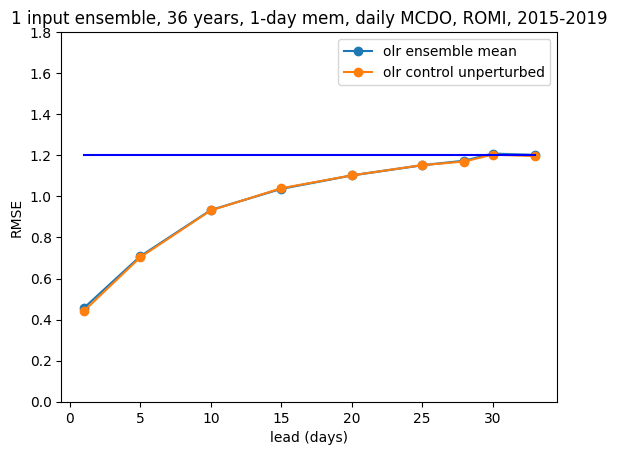

In [6]:
# fig1, ax1 = plt.subplots(figsize=(10,4))
yrlen = 36
lead = [1, 5, 10, 15, 20, 25, 28, 30, 33]

plt.plot(lead, np.mean(RMSE_olr, axis=1), 'o-', label='olr ensemble mean')
plt.fill_between(lead, np.min(RMSE_olr, axis=1), np.max(RMSE_olr, axis=1), alpha=0.3)

plt.plot(lead, RMSEctl_olr, 'o-', label='olr control unperturbed')

# plt.plot(lead, np.mean(RMSE_u200, axis=1), 'o-', label='u200')
# plt.fill_between(lead, np.min(RMSE_u200, axis=1), np.max(RMSE_u200, axis=1), alpha=0.3)

plt.plot(lead, 1.2 * np.ones(len(lead)), color='b')
plt.legend()
if yrlen == 94:
    yrlen = 114
plt.title('1 input ensemble, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')
plt.ylim([0,1.8])

(0.2, 1.1)

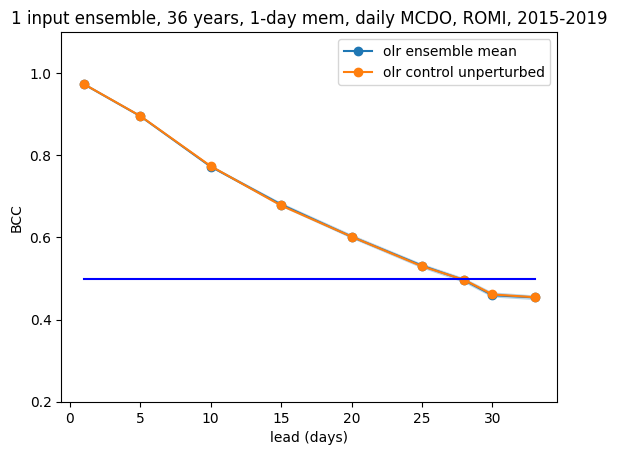

In [7]:
# fig1, ax1 = plt.subplots(figsize=(10,4))
plt.plot(lead, np.mean(BCC_olr, axis=1), 'o-', label='olr ensemble mean')
plt.fill_between(lead, np.min(BCC_olr, axis=1), np.max(BCC_olr, axis=1), alpha=0.3)
plt.plot(lead, BCCctl_olr, 'o-', label='olr control unperturbed')

# plt.plot(lead, np.mean(BCC_u200, axis=1), 'o-', label='u200')
# plt.fill_between(lead, np.min(BCC_u200, axis=1), np.max(BCC_u200, axis=1), alpha=0.3)

plt.plot(lead, 0.5 * np.ones(len(lead)), color='b')
plt.legend()
if yrlen == 94:
    yrlen = 114
plt.title('1 input ensemble, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
plt.xlabel('lead (days)')
plt.ylabel('BCC')
plt.ylim([0.2,1.1])

In [15]:
def get_RMSE(varn):
    ivarn = 0

    # set parameters for each run
    nmem = 1  # memory time steps
    yrsta = 1979  # starting year in training
    varnum = 1  # number of input maps
    yrlen = 36  # how many years in the training dataset. 94 is actually 114. 
    flg = 'trop'  # 'trop' means [-20, 20], '60deg' means [-60, 60]
    # varn = ["olr"]  # "prep", 

    fnROMI = '/global/homes/l/linyaoly/ERA5/reanalysis/cal_ROMI/ROMI_ERA5_daily_'+str(yrsta)+'to2021.nc'  # file path for the obs ROMI
    dirn = '/global/homes/l/linyaoly/ERA5/script/Unet4MJO/'+str(varnum)+'maps_MCDO_'+str(yrlen)+'yrtraining_ROMIERA5_filtered_'+flg+'/ROMI_dp0102_1dmem_'+varn[ivarn]+'/'  # directory path for the output

    lead = [1, 5, 10, 15, 20, 25, 28, 30, 33]   # select the prediction lead
    # lead = [1, 5, 10, 13, 15, 25, 30]   # select the prediction lead
    # get initial phase
    iniROMI = xr.open_dataset(fnROMI)

    if nmem == 1:
        a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
        b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
    elif nmem == 30:
        a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
        b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

    iniROMI = xr.concat((a,b), dim='time')
    del a 
    del b 
    ROMI1 = iniROMI['ROMI'][:,0]
    ROMI2 = iniROMI['ROMI'][:,1]
    Phase = np.zeros(len(ROMI1))

    for i in np.arange(len(ROMI1)):
        Phase[i] = get_phase(ROMI2[i],-ROMI1[i])

    # Phase

    # analyze error source
    RMSE = []
    err  = []
    ds = []
    pha_err = []

    for ilead, leadmjo in zip(np.arange(len(lead)), lead): 
        # combine 2015-2019 prediction for the lead
        dsp = []
        dst = []
        dspstd = []

        for yn in np.arange(2015,2020):
            fnp=dirn + 'predicted_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnt=dirn + 'truth_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'
            fnpstd=dirn + 'predicted_disstd_MCDO_UNET_'+str(varn[ivarn])+flg+'_ROMIERA5_'+str(yrlen)+'yr_lead' + str(leadmjo) + '_dailyinput_mem'+str(nmem)+'d' + str(yn) + '.csv'

            df = pd.read_csv(fnp,index_col=None, header=None, names=['ROMIp1','ROMIp2'])
            dsp.append(df)
            del df 
            df = pd.read_csv(fnt,index_col=None, header=None, names=['ROMIt1','ROMIt2'])
            dst.append(df)
            del df 
            df = pd.read_csv(fnpstd,index_col=None, header=None, names=['std1','std2'])
            dspstd.append(df)
            del df 

        dsp0 = pd.concat(dsp, axis=0, ignore_index=True)
        dst0 = pd.concat(dst, axis=0, ignore_index=True)
        dspstd0 = pd.concat(dspstd, axis=0, ignore_index=True)

        ds0 = pd.concat((dsp0,dst0,dspstd0), axis=1)

        ds.append(ds0)
        del ds0
            
        iniROMI = xr.open_dataset(fnROMI)
        
        if nmem == 1:
            a = iniROMI.sel(time=slice('2015-01-01','2016-12-30'))
            b = iniROMI.sel(time=slice('2017-01-01','2019-12-31'))
        elif nmem == 30:
            a = iniROMI.sel(time=slice('2015-01-30','2017-01-28'))
            b = iniROMI.sel(time=slice('2017-01-30','2020-01-29'))

        iniROMI = xr.concat((a,b), dim='time')
        del a 
        del b 
        ROMI1 = iniROMI['ROMI'][:,0]
        ROMI2 = iniROMI['ROMI'][:,1]
        IniAmp = np.sqrt(ROMI1 * ROMI1 + ROMI2 * ROMI2)
        ds[ilead]['IniAmp'] = IniAmp.values 
        ds[ilead]['time'] =  iniROMI.time.values
        ds[ilead]['month'] = pd.DatetimeIndex(ds[ilead].time).month
        ds[ilead]['Phase'] = Phase

        std1 = ds[ilead]['std1']
        std2 = ds[ilead]['std2']
        std = np.sqrt(std1*std1+std2*std2)
        ds[ilead]['std'] = std.values

        # finish combination
        # evaluation starts 
        ds0 = ds[ilead].copy()
        dstmp = ds0.loc[ds0['IniAmp']>=1]
        ds[ilead] = dstmp.copy()
        del ds0 
        del dstmp

        r1p = np.asarray(ds[ilead]['ROMIp1'])
        r2p = np.asarray(ds[ilead]['ROMIp2'])
        r1t = np.asarray(ds[ilead]['ROMIt1'])
        r2t = np.asarray(ds[ilead]['ROMIt2'])
        std = np.asarray(ds[ilead]['std'])

        d = (r1t-r1p)*(r1t-r1p)+(r2t-r2p)*(r2t-r2p)
        ds[ilead]['RMSE'] = np.sqrt(d)
        RMSE.append(np.sqrt(d))  # RMSE at each time step
        err.append(std)

        a = r1t * r2p - r2t * r1p 
        b = r1t * r1p + r2t * r2p
        c = a / b 
        d = np.arctan(c) * 180. / np.pi
        ds[ilead]['pha_err'] = d
        pha_err.append(d)

    return RMSE, err, pha_err

In [16]:
RMSE_olr, err_olr, pha_err_olr = np.asarray(get_RMSE(["olr"]))
RMSE_u200, err_u200, pha_err_u200 = np.asarray(get_RMSE(["u200"]))

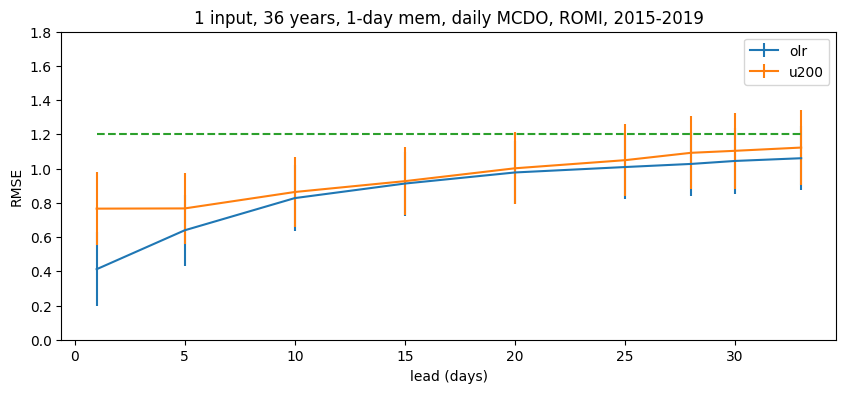

In [17]:

fig2, ax2 = plt.subplots(figsize=(10,4))

avRMSE_olr = np.mean(RMSE_olr,axis=1)
averr_olr = np.mean(err_olr,axis=1)
ax2.errorbar(lead, avRMSE_olr, yerr=averr_olr, label='olr')
avRMSE_u200 = np.mean(RMSE_u200,axis=1)
averr_u200 = np.mean(err_u200,axis=1)
ax2.errorbar(lead, avRMSE_u200, yerr=averr_u200, label='u200')

plt.legend()
plt.title(str(varnum)+' input, '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
plt.xlabel('lead (days)')
plt.ylabel('RMSE')
plt.ylim([0,1.8])
ax2.plot(lead,1.2*np.ones(len(lead)),'--')


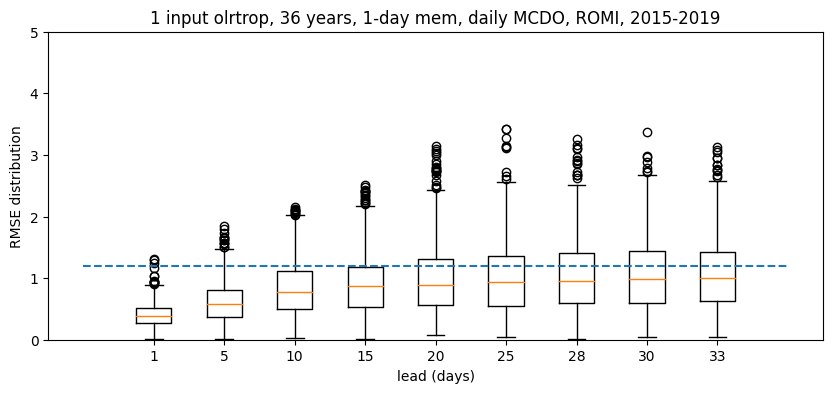

In [5]:
# ds[ilead]['time']
fig3, ax3 = plt.subplots(figsize=(10,4))
ax3.boxplot(RMSE)
ax3.set_xticklabels(lead)
plt.xlabel('lead (days)')
plt.ylabel('RMSE distribution')
plt.ylim([0,5])
plt.title(str(varnum)+' input '+str(varn[ivarn])+flg+', '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019')
ax3.plot(np.arange(len(lead)+2),1.2*np.ones(len(lead)+2),'--')


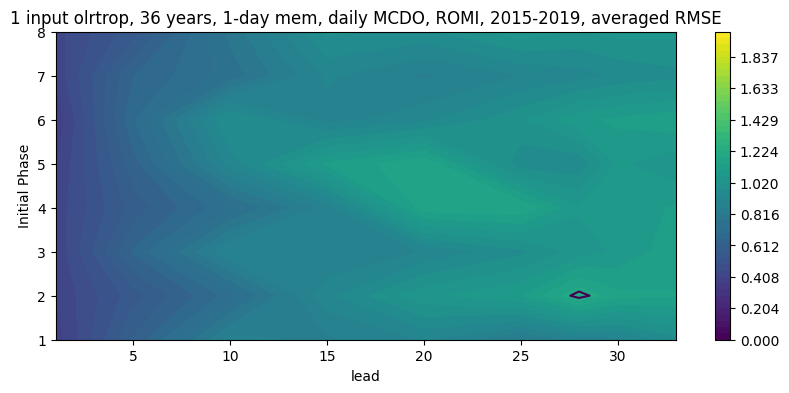

In [7]:

# lead and phase plot
ds1 = ds.copy()
RMSE_pha = np.zeros((len(lead),8))  # RMSE associated with 8 phases
fig4, ax4 = plt.subplots(figsize=(10,4))
for ilead, leadmjo in zip(np.arange(len(lead)), lead):
    RMSE_pha[ilead,:] = ds1[ilead].groupby(['Phase']).mean()['RMSE']

del ds1
h = ax4.contourf(lead, np.arange(1,9), np.transpose(RMSE_pha), levels = np.linspace(0,2,50))
# ax.legend(ncol=len(lead))
ax4.set_xlabel('lead')
ax4.set_ylabel('Initial Phase')
ax4.set_title(str(varnum)+' input '+str(varn[ivarn])+flg+', '+str(yrlen)+' years, 1-day mem, daily MCDO, ROMI, 2015-2019, averaged RMSE')
plt.colorbar(h)
ax4.contour(lead, np.arange(1,9), np.transpose(RMSE_pha),[1.2])